<a href="https://colab.research.google.com/github/EvoDmiK/TIL/blob/main/AI_study/paper_implementations/CV/YOLO_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 참고자료**
## **0-1. 도서**  
## **0-2. 논문, 학술지**
- You Only Look Once: Unified, Real-Time Object Detection [[논문 링크]](https://arxiv.org/abs/1506.02640)

## **0-3. 웹 사이트**
- 타키탸키 | Pascal VOC Dataset 탐색 및 실습 [[블로그 링크]](https://velog.io/@tataki26/open-cv)  
- shkim5616 github | YOLO-v1-for-studying | [[깃험 링크]](https://github.com/shkim5616/YOLO-v1-for-studying)

## **0-4. 데이터셋 출처**
- VOC PASCAL 데이터 셋 | [[데이터 셋 링크]](https://pjreddie.com/projects/pascal-voc-dataset-mirror/)

# **1. 데이터 셋 다운로드 받기**
- 데이터 셋을 저장할 폴더를 생성하고 링크를 통해  Pascal VOC 데이터 셋을 다운로드 받는다.

In [ ]:
!mkdir -p ./dataset/pascal/train
!mkdir -p ./dataset/pascal/test
!mkdir -p ./dataset/zips

!wget -P ./dataset/zips http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!wget -P ./dataset/zips http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!wget -P ./dataset/zips http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

In [ ]:
!tar -vxf ./dataset/zips/VOCtrainval_11-May-2012.tar -C ./dataset/pascal/train
!tar -vxf ./dataset/zips/VOCtrainval_06-Nov-2007.tar -C ./dataset/pascal/train
!tar -vxf ./dataset/zips/VOCtest_06-Nov-2007.tar -C ./dataset/pascal/test


## **1-1. 데이터 셋을 확인해 보자**
- 압축을 해제한 데이터 셋에는 Annotation 정보가 포함된 xml 파일들과, 이미지들로 구성 되어 있다.

In [ ]:
!pip install imutils
!pip install lxml
!pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imutils.paths import list_files
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2, os
import json

In [ ]:
cvt_color  = lambda image: cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
get_coord  = lambda tag, coord, type=int: float(tag.select(coord)[0].text) if type == float else int(tag.select(coord)[0].text)
xml_parser = lambda xml_path: bs(open(xml_path, 'r'), 'lxml')

def show_image(image, cvt = False):
  if cvt: image = cvt_color(image)

  plt.imshow(image)
  plt.axis(False)

  return image

In [ ]:
DATASET_PATH       = 'dataset/pascal'
TRAIN_DATASET_PATH = f'{DATASET_PATH}/train/VOCdevkit'

older_xml_paths = sorted(list_files(f'{TRAIN_DATASET_PATH}/VOC2007/Annotations'))

xml_path = older_xml_paths[0]
soup = xml_parser(xml_path)

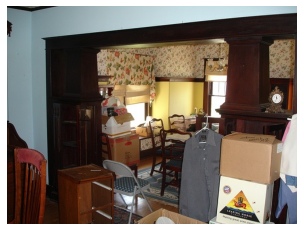

In [ ]:
file_name    = soup.select('filename')[0].text
folder_name  = '/'.join(xml_path.split(os.path.sep)[:-2])
image_path   = f'{folder_name}/JPEGImages/{file_name}'

image = cv2.imread(image_path)
image = show_image(image, cvt = True)

- xml 파일이 object > bndbox 안에 좌표가 있어 bs4를 이용해 좌표정보를 가져온다.

[]

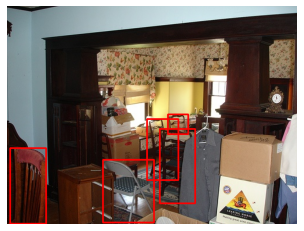

In [ ]:
bboxes = soup.select('object > bndbox')
bboxes = [(get_coord(bbox, 'xmin'), get_coord(bbox, 'ymin'), get_coord(bbox, 'xmax'), get_coord(bbox, 'ymax')) for bbox in bboxes]

for bbox in bboxes:
  x_min, y_min, x_max, y_max = bbox
  cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

_ = show_image(image)

soup.select('obj')

## **1-2. 데이터 셋을 전처리 해보자**
- PASCAL VOC 형식의 xml 데이터 셋을 yolo format으로 변경하여 준다.

In [ ]:
def pascal2yolo(bbox, w, h):
  x_min, y_min, x_max, y_max = bbox

  ## 중심좌표와 너비, 높이는 원래 좌표 값에서 
  ## 이미지의 너비, 높이를 나누어 정규화 해준다.
  center_x = ((x_max + x_min) / 2) / w
  center_y = ((y_max + y_min) / 2) / h

  W = (x_max - x_min) / w
  H = (y_max - y_min) / h

  return (center_x, center_y, W, H)

def save_yolo(soup):

  file_name = soup.select('filename')
  width     = int(soup.select('size > width')[0].text) 
  height    = int(soup.select('size > height')[0].text)

  labels = []
  for obj in soup.select('object'):
      bboxes = [(
                get_coord(bbox, 'xmin', float), 
                get_coord(bbox, 'ymin', float), 
                get_coord(bbox, 'xmax', float), 
                get_coord(bbox, 'ymax', float)) 
                for bbox in soup.select('bndbox')]

      # 좌표 정규화 (xml -> yolo 형식으로)
      bboxes = [pascal2yolo(bbox, width, height) for bbox in bboxes]
      
      label = [lb.text for lb in obj.select('name')]
      labels.extend(label)

  return bboxes, labels, file_name[0].text

In [ ]:
## pascal voc 데이터 셋에 있는 20개의 레이블들
label_set = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
    'dog', 'foot', 'hand', 'head', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
  ]

## 전처리 결과를 폴더에 저장해주자
os.makedirs('dataset/preproc', exist_ok = True)
for idx, xml_path in enumerate(older_xml_paths):
  soup = xml_parser(xml_path)
  bboxes, labels, fname = save_yolo(soup)
  fname, _ = os.path.splitext(fname)

  txt_string = ''
  for bbox, label in zip(bboxes, labels):
      bbox_str  = ' '.join([str(b) for b in bbox])
      label_idx = label_set.index(label)

      txt_string += f'{label_idx} {bbox_str}\n'
      open(f'dataset/preproc/{fname}.txt', 'a').write(txt_string)
  
  

In [ ]:
open('classes.txt', 'w', encoding = 'utf-8').write(json.dumps(label_set))

219

# **2. YOLO v1 모델을 구현해보자**      

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

## **2-1. 신경망을 구성해보자**  
- 논문에서 (448, 448)의 이미지를 입력받아 최종적으로 7x7x30의 아웃풋이 나오도록 구현되어 있음. 
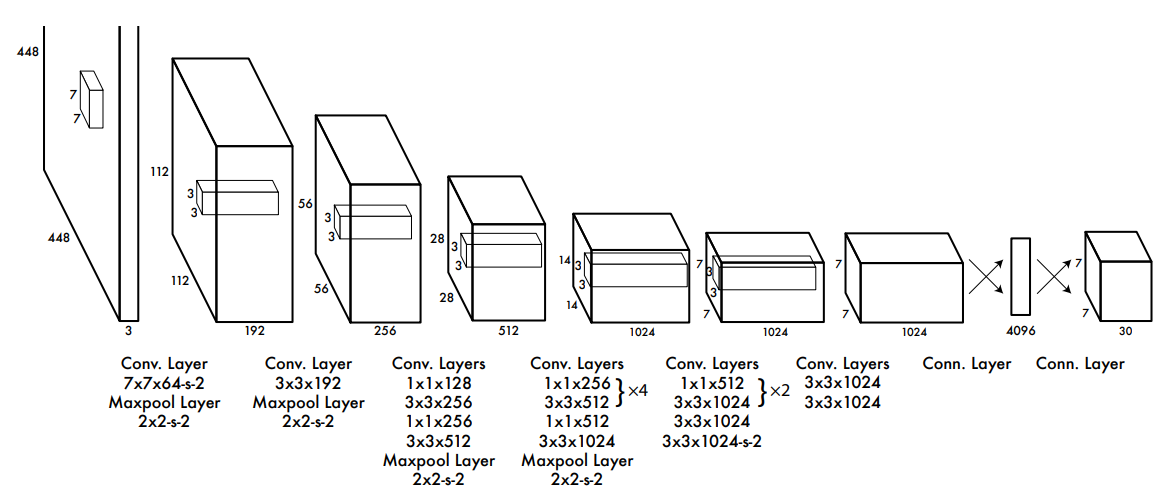

In [ ]:
architecture = [
    ## out_channels, kernel_size, stride, padding
    (64, 7, 2, 3),
    'M',
    (192, 3, 1, 1),
    'M',
    (128, 1, 1, 0),
    (256, 3, 1, 1),
    (256, 1, 1, 0),
    (512, 3, 1, 1),
    'M',
    [(256, 1, 1, 0), (512, 3, 1, 1), 4],
    (512, 1, 1, 0),
    (1024, 3, 1, 1),
    'M',
    [(512, 1, 1, 0), (1024, 3, 1, 1), 2],
    (1024, 3, 1, 1),
    (1024, 3, 2, 1),
    (1024, 3, 1, 1),
    (1024, 3, 1, 1),
]

In [ ]:
class CNNBlock(nn.Module):

  def __init__(self, in_channels, out_channels, **kwargs):

    super(CNNBlock, self).__init__()
    self.conv      = nn.Conv2d(in_channels, out_channels, bias = False, **kwargs)
    self.bn        = nn.BatchNorm2d(out_channels)
    self.leakyrelu = nn.LeakyReLU(0.1)

  def forward(self, x):

    x = self.conv(x)
    x = self.bn(x)
    x = self.leakyrelu(x)
    return x 

In [ ]:
class Yolov1(nn.Module):

  def __init__(self, in_channels = 3, **kwargs):
    super(Yolov1, self).__init__()
    self.architecture = architecture
    self.in_channels  = in_channels

    self.darknet = self._create_conv_layers(self.architecture)
    self.fcs = self._create_fcs(**kwargs)


  def forward(self, x):
    ## darknet | Convolution layers (feature extractor)
    x = self.darknet(x)
    x = torch.flatten(x, start_dim = 1)

    ## fcs     | Fully connected layers
    return self.fcs(x)

  ## 이 모델은 사전 학습된 모델을 사용하지 않았는데,
  ## 추후 사전학습된 모델로도 구성해 보며 테스트 예정이다.
  def _create_conv_layers(self, archutecture):

    layers = []
    in_channels = self.in_channels

    for archi in architecture:
      if type(archi) == tuple:
      
        layers += [
                    CNNBlock(in_channels,  archi[0],
                             kernel_size = archi[1],
                             stride      = archi[2],
                             padding     = archi[3])
                  ]

        in_channels = archi[0]

      elif type(archi) == str:
        layers += [nn.MaxPool2d(kernel_size = 2, stride = 2)]

      elif type(archi) == list:
        conv1, conv2, num_repeats = archi

        for _ in range(num_repeats):

          layers += [
                      CNNBlock(
                          in_channels,  conv1[0],
                          kernel_size = conv1[1],
                          stride      = conv1[2],
                          padding     = conv1[3])
                    ]

          layers += [
                      CNNBlock(
                          conv1[0],     conv2[0],
                          kernel_size = conv2[1],
                          stride      = conv2[2],
                          padding     = conv2[3])
                    ]

          in_channels = conv2[0]

    return nn.Sequential(*layers)


  def _create_fcs(self, split_size, num_boxes, num_classes):

    S, B, C = split_size, num_boxes, num_classes
    return nn.Sequential(
              nn.Flatten(),
              nn.Linear(1024*S*S, 4096),
              nn.Dropout(0.5),
              nn.LeakyReLU(0.1),
              nn.Linear(4096, S*S*(C+B*5))
            )

In [ ]:
## 제대로 구현되었는지 테스트 해보자
model = Yolov1(split_size = 7, 
               num_boxes = 2, num_classes = 20)

x = torch.randn((2, 3, 448, 448))
print(model(x).shape)

torch.Size([2, 1470])


## **2-2. 필요한 함수를 정의해보자**


In [ ]:
from collections import Counter, deque
import matplotlib.patches as patches

In [ ]:
class Utils:

  def IoU(box_pred:torch.tensor, box_gt:torch.tensor, box_format = "center"):

    if box_format == 'center':
      ## 중심점으로 부터 박스의 좌표를 구할때
      ## 좌표 값이 [center_x, center_y, w, h]로 들어가고 나옴
      x1_pred = box_pred[..., 0] - (box_pred[..., 2] / 2)
      y1_pred = box_pred[..., 1] - (box_pred[..., 3] / 2)
      x2_pred = box_pred[..., 0] + (box_pred[..., 2] / 2)
      y2_pred = box_pred[..., 1] + (box_pred[..., 3] / 2)

      x1_gt = box_gt[..., 0] - (box_gt[..., 2] / 2)
      y1_gt = box_gt[..., 1] - (box_gt[..., 3] / 2)
      x2_gt = box_gt[..., 0] + (box_gt[..., 2] / 2)
      y2_gt = box_gt[..., 1] + (box_gt[..., 3] / 2)

    elif box_format == 'corner':
      ## 좌표 값이 [x1, y1,x2, y2]로 주어지는 경우
      x1_pred = box_pred[..., 0]
      y1_pred = box_pred[..., 1]
      x2_pred = box_pred[..., 2]
      y2_pred = box_pred[..., 3]

      x1_gt = box_gt[..., 0]
      y1_gt = box_gt[..., 1]
      x2_gt = box_gt[..., 2]
      y2_gt = box_gt[..., 3]

    
    x1_inter = torch.max(x1_pred, x1_gt)
    x2_inter = torch.min(x2_pred, x2_gt)

    y1_inter = torch.max(y1_pred, y1_gt)
    y2_inter = torch.min(y2_pred, y2_gt)

    area_inter = (x2_inter - x1_inter).clamp(0) * (y2_inter - y1_inter).clamp(0)
    area_pred  = abs((x2_pred - x1_pred)*(y2_pred - y1_pred))
    area_gt    = abs((x2_gt - x1_gt) * (y2_gt - y1_gt))

    ## 분자가 0이 되지 않도록 하는 값 추가
    eps = 1e-6
    return area_inter / (area_pred + area_gt - area_inter + eps)

  
  def NMS(bboxes, iou_threshold, conf_threshold, box_format = 'corner'):

    ## bbox는 [검출 레이블, confidence, x1, y1, x2, y2]로 구성된 리스트
    assert type(bboxes) == list

    ## confidence threshold 보다 작은 녀석들 제거
    bboxes = [bbox for bbox in bboxes if bbox[1] > conf_threshold]

    ## confidence가 높은 녀석 순서로 내림차순 정렬
    bboxes = sorted(bboxes, key = lambda x: x[1], reverse = True)

    ## NMS 이후에 남아있는 박스들
    nms_bboxes = []
    bboxes = deque(bboxes)

    while bboxes:
      base_box = bboxes.popleft()

      bboxes = deque([
                        bbox for bbox in bboxes
                        if (bbox[0] != base_box[0])
                        or (Utils.IoU(
                              torch.tensor(base_box[2:]),
                              torch.tensor(bbox[2:]),
                              box_format = box_format
                            )) < iou_threshold
                    ])
      
      nms_bboxes.append(base_box)

    return nms_bboxes


  def mAP(boxes_pred, boxes_gt, iou_threshold = 0.5, box_format = 'center', n_classes = 20):

    average_precisions = []
    eps = 1e-6

    for class_idx in range(n_classes):

      ## 현재 레이블에 맞게 검출한 박스들만 걸러내는 작업
      detections    = [det for det in boxes_pred if det[1] == class_idx]
      ground_truths = [gt for gt in boxes_gt if gt[1] == class_idx]

      ## 이미지 별로 ground truth의 bbox 갯수가 몇 개인지 집계
      amount_bboxes = Counter([gt[0] for gt in ground_truths])
      for k, v in amount_bboxes.items(): amount_bboxes[k] = torch.zeros(v)

      ## 검출한 녀석들 중에서 confidence 순으로 내림차 순 정렬
      detections = sorted(detections, key = lambda x: x[2], reverse = True)
      
      ## 제대로 잡은 녀석과 잡지 말아야할 녀석을 잡은 녀석을 표시하는 텐서
      TP = torch.zeros((len(detections)))
      FP = torch.zeros((len(detections)))
      total_true_bboxes = len(ground_truths)

      ## 해당 레이블로 검출한 녀석이 없는 경우에는 그냥 넘김
      if total_true_bboxes == 0: continue

      for det_idx, detection in enumerate(detections):

        ## ground truth 이미지 중에서 검출한 이미지와 동일한 이미지만 남김
        gt_images = [
                      bbox for bbox in ground_truths if bbox[0] == detection[0]
                    ]

        num_gts, best_iou = len(gt_images), 0
        for idx, gt in enumerate(gt_images):
          iou = Utils.IoU(
                  torch.tensor(detection[3:]),
                  torch.tensor(gt[3:]),
                  box_format = box_format
                )
          if iou > best_iou:
            best_iou    = idx
            best_gt_idx = idx

        if best_iou > iou_threshold:
          if amount_bboxes[detection[0]][best_gt_idx] == 0:
            TP[det_idx] = 1
            amount_bboxes[detection[0]][best_gt_idx] = 1

          else:
            FP[det_idx] = 1

        else:
          FP[det_idx] = 1
      
      TP_sum = torch.cumsum(TP, dim = 0)
      FP_sum = torch.cumsum(FP, dim = 0)

      recalls    = TP_sum / (total_true_bboxes + eps)
      precisions = torch.divide(TP_sum, (TP_sum + FP_sum + eps))
      precisions = torch.cat((torch.tensor([1]), precisions))
      recalls    = torch.cat((torch.tensor([0]), recalls))

      ## torch.trapz() 사다리꼴 적분. 즉, AP를 구하는 부분
      average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)




In [ ]:
## 제대로 구현되었는지 테스트 해보자

box_pred  = torch.tensor([20, 30, 120, 130])
box_pred2 = torch.tensor([15, 25, 115, 125])
box_gt    = torch.tensor([25, 35, 125, 135])

nms_boxes = Utils.NMS([
    ## ground truth와 거의 근접하게 검출한 녀석
    ['dove', 0.8, 25, 35, 125, 135], 

    ## 첫 번째 녀석과 IoU가 낮게 측정되는 녀석
    ['pigeon', 0.9, 50, 135, 150, 235],

    ## confidence가 낮은 녀석
    ['pigeon', 0.3, 20, 30, 120, 130], 

    ## 첫 번쩨 녀석과 레이블이 겹치는 녀석
    ['dove', 0.7, 15, 25, 115, 125]], 0.3, 0.5)

print(f'IoU       | {Utils.IoU(box_gt, box_pred)}')
print(f'IoU2      | {Utils.IoU(box_gt, box_pred2)}')
print(f'NMS Boxes | {nms_boxes}')

IoU       | 0.8563773036003113
IoU2      | 0.7313019633293152
NMS Boxes | [['pigeon', 0.9, 50, 135, 150, 235], ['dove', 0.8, 25, 35, 125, 135]]
